In [125]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cftime

In [2]:
file_dir = '/glade/u/home/marielj/clm_frost/cesm_cases/stored-data/'

#Find all case directories
dirs = glob.glob(file_dir + '*', recursive = True)

#Strip the string to get case name
case_names = [string[55:] for string in dirs]

#Remove and store the control case
control_case = [case for case in case_names if 'CONTROL' in case][0]
case_names.remove(control_case)

In [3]:
control_case

'mbp_tuning_nospinup_CONTROL_v0'

In [4]:
case_names

['mbp_tuning_nospinup_BASEFLOW_v5',
 'mbp_tuning_nospinup_BASEFLOW_v2',
 'mbp_tuning_nospinup_BASEFLOW_v0',
 'mbp_tuning_nospinup_BASEFLOW_v4',
 'mbp_tuning_nospinup_BASEFLOW_v1',
 'mbp_tuning_nospinup_BASEFLOW_v3',
 'mbp_tuning_nospinup_BASEFLOW_v6']

In [5]:
'''Upload Control Case'''
#Year for calibration
year = 2012

#Navigate to directory and import netcdf file
control_file_dir = file_dir + control_case + '/'
control_file_format = 'mbp_tuning_nospinup_CONTROL_v0.clm2.h1.' + str(year) + '-01-01-00000.nc'

control = xr.load_dataset(control_file_dir + control_file_format)

In [6]:
control

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levlak: 10, levdcmp: 1, time: 365,
                   hist_interval: 2, lndgrid: 1, levsoi: 20)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 1.0
  * time          (time) object 2012-01-01 00:00:00 ... 2012-12-31 00:00:00
Dimensions without coordinates: hist_interval, lndgrid, levsoi
Data variables: (12/27)
    mcdate        (time) int32 20120101 20120102 20120103 ... 20121230 20121231
    mcsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mdcur         (time) int32 365 366 367 368 369 370 ... 725 726 727 728 729
    mscur         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nstep         (time) int32 17520 17568 17616 17664 ... 34896 34944 34992
    time_bounds   (time, hist_interval) object 2011-12-31 00:00:00 ... 2012-1...
    ...            ...
    RAIN          (time, lndgrid) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SNOW          (time, lndgrid) float32 1.762e-05 5.875e-06 ... 2.937e-06 0.0
    SOILICE       (time, levsoi, lndgrid) float32 10.19 11.14 10.0 ... 0.0 0.0
    TSA           (time, lndgrid) float32 266.0 268.9 261.2 ... 259.2 261.7
    ZWT           (time, lndgrid) float32 5.047 5.048 5.048 ... 5.697 5.701
    ZWT_PERCH     (time, lndgrid) float32 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/23 12:43:22
    source:                                    Community Land Model CLM4.0
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          day_1
    Time_constant_3Dvars_filename:             ./mbp_tuning_nospinup_CONTROL_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

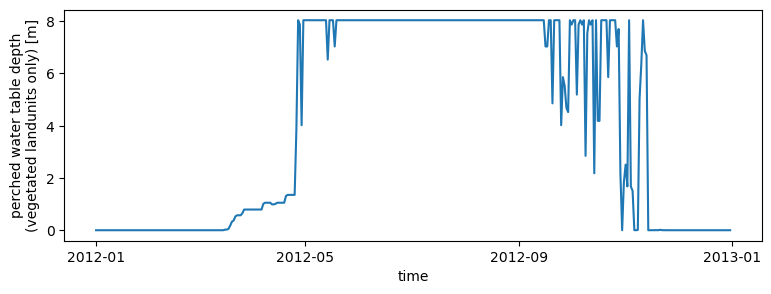

In [7]:
control.ZWT_PERCH.plot(aspect = 3, size = 3)

In [98]:
'''Open Parameter Tuning Cases'''
param = 'BASEFLOW' #One of 'slopebeta', 'mu', 'baseflow'
param_values = {'SLOPEBETA': [2, 1.5, 1.25, 1, 0.80, 0.66, 0.50], 
                'MU': [2, 1.5, 1.25, 1, 0.80, 0.66, 0.50],
                'BASEFLOW': [10e-8, 10e-7, 10e-6, 10e-4, 10e-2, 1, 2]}

#filter out param cases
param_cases = [case for case in case_names if param in case]
param_datasets = []

#loop through values and import the data, concatenating together
for case in np.sort(param_cases):
    #pull tuning instance
    tuning_i = case[-1]
    
    #param file format
    param_file_format = 'mbp_tuning_nospinup_' + param + '_v' + str(tuning_i) + '.clm2.h1.' + str(year) + '-01-01-00000.nc'
    param_file_dir = file_dir + case + '/'
    
    #load dataset
    dataset = xr.load_dataset(param_file_dir + param_file_format)
    
    #add variable for tuning instance
    dataset = dataset.assign_coords(case = int(tuning_i))

    #append to list
    param_datasets.append(dataset)
    
#concat all datasets
#parameter = xr.concat(param_datasets, 'time')

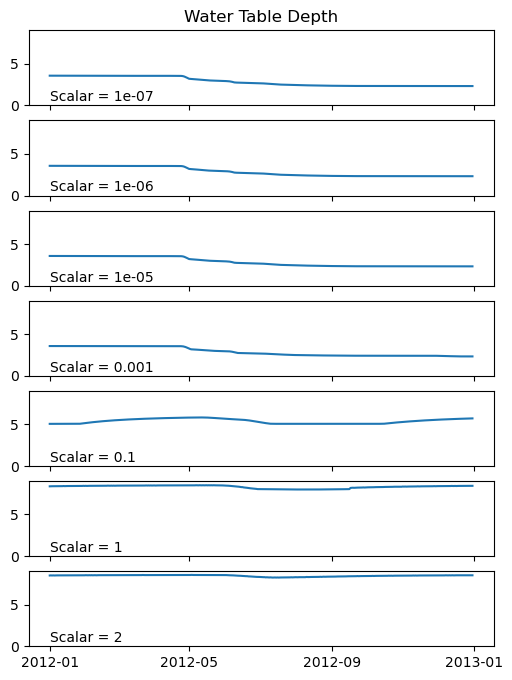

In [147]:
fig, axs = plt.subplots(nrows=7, ncols=1,
                        sharex = True,
                        figsize = (6,8))

# loop through axes
for i in range(0, len(param_datasets)):
    data = param_datasets[i]
    
    #plot
    axs[i].plot(data.time, data.ZWT)
    
    #plot formatting
    start = cftime.DatetimeNoLeap(2012, 1, 1, 0, 0, 0, 0, has_year_zero=True)
    axs[i].text(start, 0.5, 'Scalar = ' + str(param_values['BASEFLOW'][i]))
    axs[i].set_ylim(0, 9)

axs[0].set_title("Water Table Depth")

plt.show()

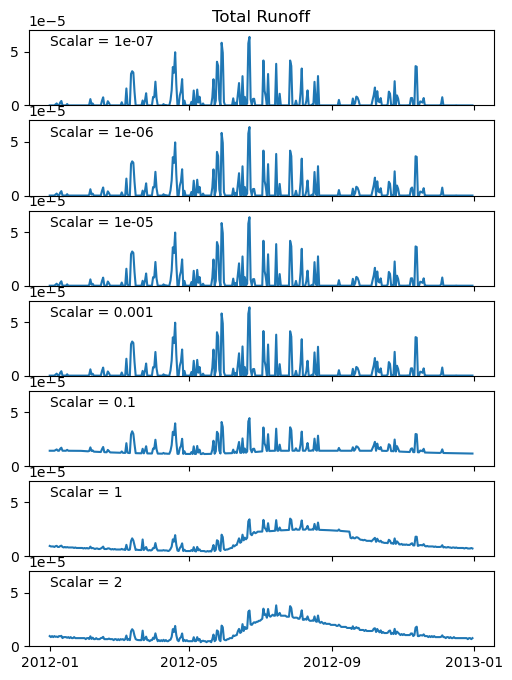

In [140]:
fig, axs = plt.subplots(nrows=7, ncols=1,
                        sharex = True,
                        figsize = (6,8))

# loop through axes
for i in range(0, len(param_datasets)):
    data = param_datasets[i]
    
    #plot
    axs[i].plot(data.time, data.QRUNOFF)
    
    #plot formatting
    start = cftime.DatetimeNoLeap(2012, 1, 1, 0, 0, 0, 0, has_year_zero=True)
    axs[i].text(start, 5.5*1e-5, 'Scalar = ' + str(param_values['BASEFLOW'][i]))
    axs[i].set_ylim(0, 7*1e-5)

axs[0].set_title("Total Runoff")

plt.show()

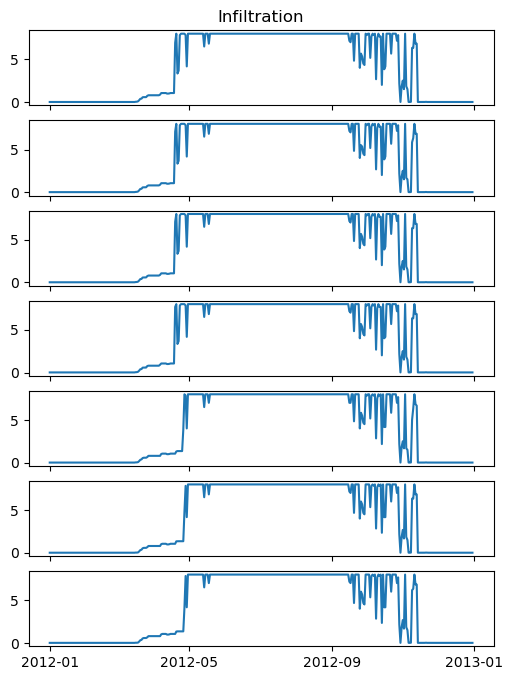

In [145]:
fig, axs = plt.subplots(nrows=7, ncols=1,
                        sharex = True,
                        figsize = (6,8))

# loop through axes
for i in range(0, len(param_datasets)):
    data = param_datasets[i]
    
    #plot
    axs[i].plot(data.time, data.ZWT_PERCH)
    
    #plot formatting
    start = cftime.DatetimeNoLeap(2012, 1, 1, 0, 0, 0, 0, has_year_zero=True)
    #axs[i].text(start, 0.5, 'Scalar = ' + str(param_values['BASEFLOW'][i]))
    #axs[i].set_ylim(0, 9)

axs[0].set_title("Infiltration")

plt.show()